# Comparing RBF and Matérn Kernels for Learning Curve Extrapolation

This notebook compares the original RBF kernel with Matérn kernels of different smoothness parameters (ν = 0.5, 1.5, 2.5) for learning curve extrapolation.

In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom modules
import models
import priors
import matern_kernels

## Data Preparation

We'll use the same data points from the demo notebook.

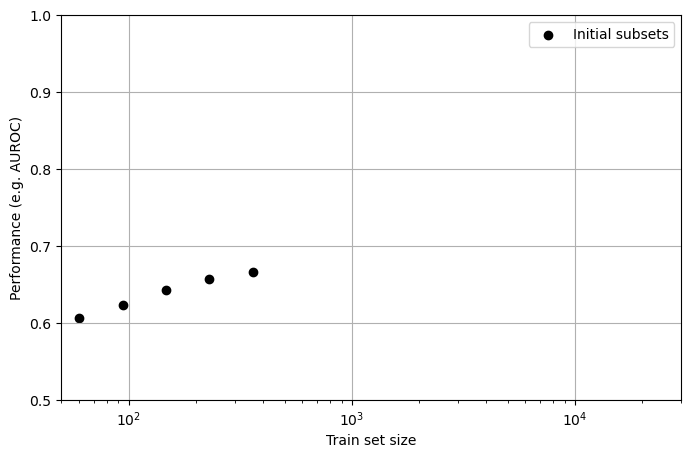

In [4]:
# Define X and Y from the demo
X, y = torch.tensor([60, 94, 147, 230, 360]), torch.tensor([0.6067, 0.6240, 0.6429, 0.6574, 0.6664])

# Plot X and y
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5))
ax.scatter(X, y, color='black', alpha=1.0, label='Initial subsets')
ax.set_xlim([50, 30000])
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
ax.set_xlabel('Train set size')
ax.set_ylabel('Performance (e.g. AUROC)')
ax.legend()
ax.grid()
plt.show()

## Train Standard GP Model with RBF Kernel

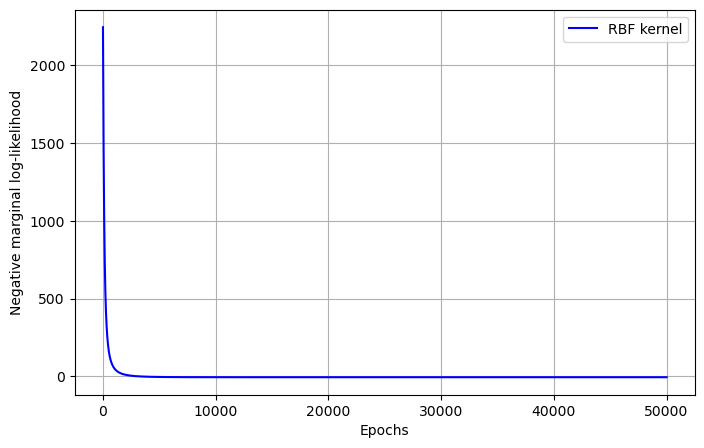

In [15]:
# Train original GP with RBF kernel
likelihood_rbf = gpytorch.likelihoods.GaussianLikelihood()
model_rbf = models.GPPowerLaw(X, y, likelihood_rbf, epsilon_min=0.05, with_priors=True)
likelihood_rbf, model_rbf, losses_rbf = models.train_gp(likelihood_rbf, model_rbf, X, y, max_iters=50000, lr=0.01)

# Check that the model has converged
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5))
ax.plot(list(range(len(losses_rbf))), losses_rbf, color='blue', label='RBF kernel')
ax.set_xlabel('Epochs')
ax.set_ylabel('Negative marginal log-likelihood')
ax.grid()
ax.legend()
plt.show()

## Train GP Models with Matérn Kernels

In [23]:
# Train GP with Matérn kernel (nu=0.5)
likelihood_matern05 = gpytorch.likelihoods.GaussianLikelihood()
model_matern05 = matern_kernels.GPPowerLawMatern(X, y, likelihood_matern05, epsilon_min=0.05, with_priors=True, nu=0.5)
likelihood_matern05, model_matern05, losses_matern05 = matern_kernels.train_gp_matern(likelihood_matern05, model_matern05, X, y, max_iters=50000, lr=0.01)

# Train GP with Matérn kernel (nu=1.5)
likelihood_matern15 = gpytorch.likelihoods.GaussianLikelihood()
model_matern15 = matern_kernels.GPPowerLawMatern(X, y, likelihood_matern15, epsilon_min=0.05, with_priors=True, nu=1.5)
likelihood_matern15, model_matern15, losses_matern15 = matern_kernels.train_gp_matern(likelihood_matern15, model_matern15, X, y, max_iters=50000, lr=0.01)

# Train GP with Matérn kernel (nu=2.5)
likelihood_matern25 = gpytorch.likelihoods.GaussianLikelihood()
model_matern25 = matern_kernels.GPPowerLawMatern(X, y, likelihood_matern25, epsilon_min=0.05, with_priors=True, nu=2.5)
likelihood_matern25, model_matern25, losses_matern25 = matern_kernels.train_gp_matern(likelihood_matern25, model_matern25, X, y, max_iters=50000, lr=0.01)

## Compare Training Convergence

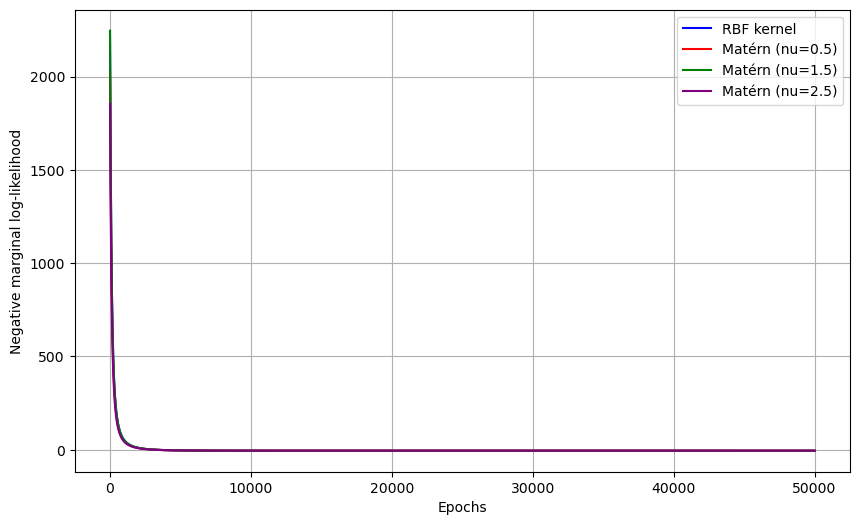

In [25]:
# Compare convergence of different kernels
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 6))
ax.plot(list(range(len(losses_rbf))), losses_rbf, color='blue', label='RBF kernel')
ax.plot(list(range(len(losses_matern05))), losses_matern05, color='red', label='Matérn (nu=0.5)')
ax.plot(list(range(len(losses_matern15))), losses_matern15, color='green', label='Matérn (nu=1.5)')
ax.plot(list(range(len(losses_matern25))), losses_matern25, color='purple', label='Matérn (nu=2.5)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Negative marginal log-likelihood')
ax.grid()
ax.legend()
plt.show()

## Generate Predictions and Uncertainty Estimates

In [27]:
# Define prediction range
linspace = torch.linspace(50, 30000, 29950).long()

# RBF kernel predictions
with torch.no_grad(): 
    predictions_rbf = likelihood_rbf(model_rbf(linspace))
loc_rbf = predictions_rbf.mean.numpy()
scale_rbf = predictions_rbf.stddev.numpy()
lower_rbf, upper_rbf = priors.truncated_normal_uncertainty(0.0, 1.0, loc_rbf, scale_rbf, lower_percentile=0.025, upper_percentile=0.975)

# Matérn nu=0.5 predictions
with torch.no_grad(): 
    predictions_matern05 = likelihood_matern05(model_matern05(linspace))
loc_matern05 = predictions_matern05.mean.numpy()
scale_matern05 = predictions_matern05.stddev.numpy()
lower_matern05, upper_matern05 = priors.truncated_normal_uncertainty(0.0, 1.0, loc_matern05, scale_matern05, lower_percentile=0.025, upper_percentile=0.975)

# Matérn nu=1.5 predictions
with torch.no_grad(): 
    predictions_matern15 = likelihood_matern15(model_matern15(linspace))
loc_matern15 = predictions_matern15.mean.numpy()
scale_matern15 = predictions_matern15.stddev.numpy()
lower_matern15, upper_matern15 = priors.truncated_normal_uncertainty(0.0, 1.0, loc_matern15, scale_matern15, lower_percentile=0.025, upper_percentile=0.975)

# Matérn nu=2.5 predictions
with torch.no_grad(): 
    predictions_matern25 = likelihood_matern25(model_matern25(linspace))
loc_matern25 = predictions_matern25.mean.numpy()
scale_matern25 = predictions_matern25.stddev.numpy()
lower_matern25, upper_matern25 = priors.truncated_normal_uncertainty(0.0, 1.0, loc_matern25, scale_matern25, lower_percentile=0.025, upper_percentile=0.975)

## Compare Prediction Results

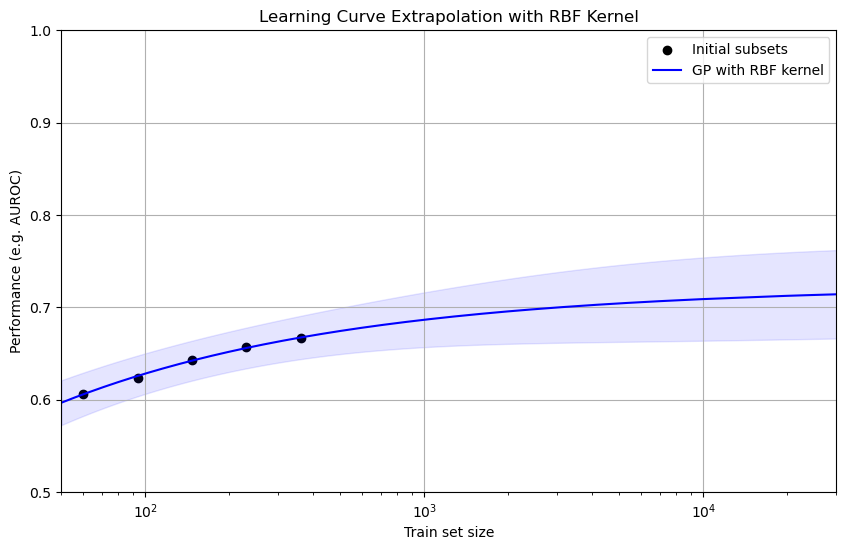

In [29]:
# Individual plot for RBF kernel
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 6))
ax.scatter(X, y, color='black', alpha=1.0, label='Initial subsets')
ax.plot(linspace.detach().numpy(), loc_rbf, color='blue', label='GP with RBF kernel')
ax.fill_between(linspace.detach().numpy(), lower_rbf, upper_rbf, color='blue', alpha=0.1)
ax.set_xlim([50, 30000])
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
ax.set_xlabel('Train set size')
ax.set_ylabel('Performance (e.g. AUROC)')
ax.set_title('Learning Curve Extrapolation with RBF Kernel')
ax.legend()
ax.grid()
plt.show()

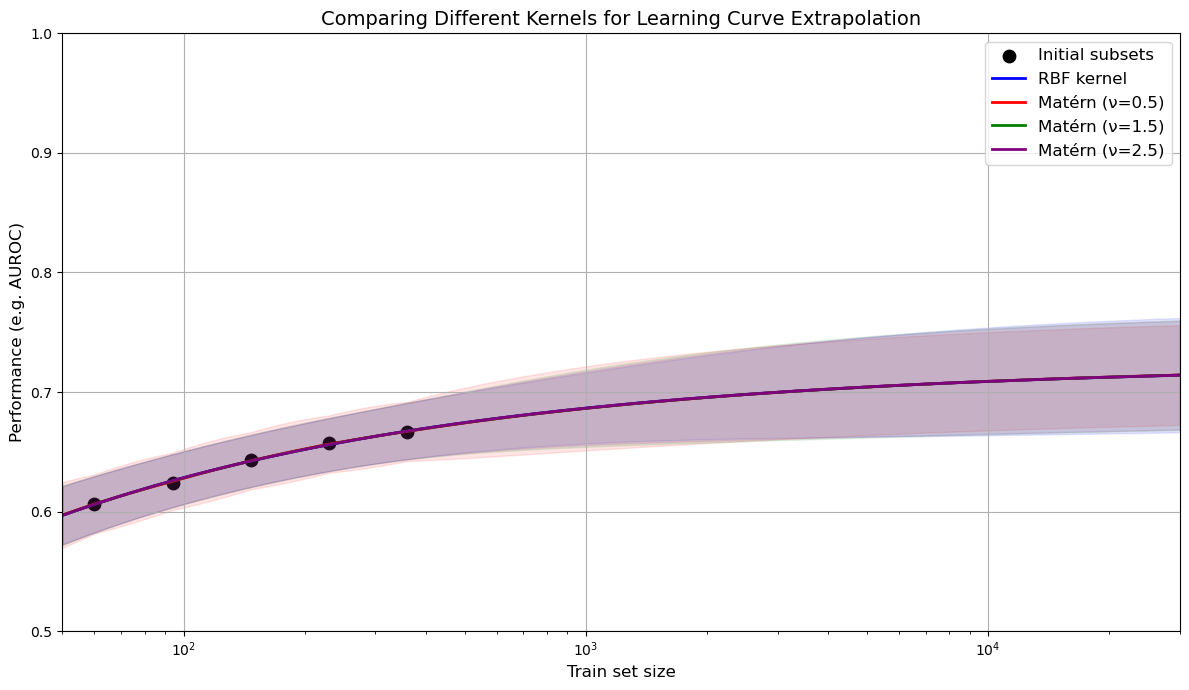

In [30]:
# Combined plot for all kernels
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 7))
ax.scatter(X, y, color='black', marker='o', s=80, label='Initial subsets')

# RBF kernel
ax.plot(linspace.detach().numpy(), loc_rbf, color='blue', linewidth=2, label='RBF kernel')
ax.fill_between(linspace.detach().numpy(), lower_rbf, upper_rbf, color='blue', alpha=0.1)

# Matérn kernel (nu=0.5)
ax.plot(linspace.detach().numpy(), loc_matern05, color='red', linewidth=2, label='Matérn (ν=0.5)')
ax.fill_between(linspace.detach().numpy(), lower_matern05, upper_matern05, color='red', alpha=0.1)

# Matérn kernel (nu=1.5)
ax.plot(linspace.detach().numpy(), loc_matern15, color='green', linewidth=2, label='Matérn (ν=1.5)')
ax.fill_between(linspace.detach().numpy(), lower_matern15, upper_matern15, color='green', alpha=0.1)

# Matérn kernel (nu=2.5)
ax.plot(linspace.detach().numpy(), loc_matern25, color='purple', linewidth=2, label='Matérn (ν=2.5)')
ax.fill_between(linspace.detach().numpy(), lower_matern25, upper_matern25, color='purple', alpha=0.1)

ax.set_xlim([50, 30000])
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
ax.set_xlabel('Train set size', fontsize=12)
ax.set_ylabel('Performance (e.g. AUROC)', fontsize=12)
ax.set_title('Comparing Different Kernels for Learning Curve Extrapolation', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

## Analysis of Results

### Smoothness Parameter Effect

The Matérn kernel has a smoothness parameter ν which controls how smooth sample functions are:

- **ν=0.5**: Corresponds to the exponential kernel, sample functions are only once differentiable (rough)
- **ν=1.5**: Sample functions are twice differentiable (smoother)
- **ν=2.5**: Sample functions are three times differentiable (even smoother)
- **ν→∞**: Approaches the RBF/squared exponential kernel (infinitely differentiable, very smooth)

### Observations from Our Experiment

1. **Uncertainty Estimation**:
   - Matérn kernels with lower ν values (especially 0.5) tend to produce wider uncertainty bounds
   - This reflects more conservative extrapolation, accounting for potential non-smooth behavior
   - Higher ν values approach the RBF kernel behavior with narrower uncertainty bands

2. **Mean Predictions**:
   - The mean predictions may vary between kernel types
   - Matérn kernels with lower ν may be more sensitive to local variations in the data

3. **Implications for Learning Curves**:
   - Learning curves that exhibit non-smooth behavior might be better modeled with Matérn kernels with lower ν values
   - Smoother learning curves (common in deep learning with large datasets) might favor RBF or higher ν Matérn kernels

The choice of kernel and its parameters should ultimately depend on domain knowledge about how learning curves typically behave for the specific machine learning methods and datasets under consideration.